# Description

This notebook develops a daily flight count model for the Hartsfield Jackson International Airport (ATL) in Atlanta, GA.  It is focused on building a model for pandemic flight patterns.

Special credit should be given to the Forecasting Energy Demand developers that developed the Azure Machine Learning documentation examples: 
https://github.com/Azure/MachineLearningNotebooks

https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/

# Set up workspace

### Import packages etc

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from matplotlib import pyplot as plt
from azureml.core import Workspace, Dataset, workspace

subscription_id = 'f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17'
resource_group = 'hackathon'
workspace_name = 'Iteration1_ML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

### Set up experiment

In [2]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

### Set Up Workspace

In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'COVID_model_JP'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17
Workspace,iteration1_ml
Resource Group,hackathon
Location,eastus2
Run History Name,COVID_model_JP


### Create AmlCompute

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "flights-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Start Data Prep for Modeling

### Set up designated variables

In [5]:
target_column_name = 'counts_x'
time_column_name = 'Date'

### Read in data as dataset tabular object

In [6]:
dataset = Dataset.get_by_name(workspace, name='ATL_training_autoML').with_timestamp_columns(fine_grain_timestamp=time_column_name) 
#preview first 5 rows
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19556,ATL,2019-01-01,GA,952,Tuesday,1,1,January,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19562,ATL,2019-01-02,GA,1241,Wednesday,2,2,January,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19568,ATL,2019-01-03,GA,1162,Thursday,3,3,January,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19574,ATL,2019-01-04,GA,1164,Friday,4,4,January,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19580,ATL,2019-01-05,GA,865,Saturday,5,5,January,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Exploration

In [7]:
explore =dataset.time_between(datetime(2020, 3, 1, 0), datetime(2020, 9, 30, 0))
explore=explore.to_pandas_dataframe().reset_index(drop=True)

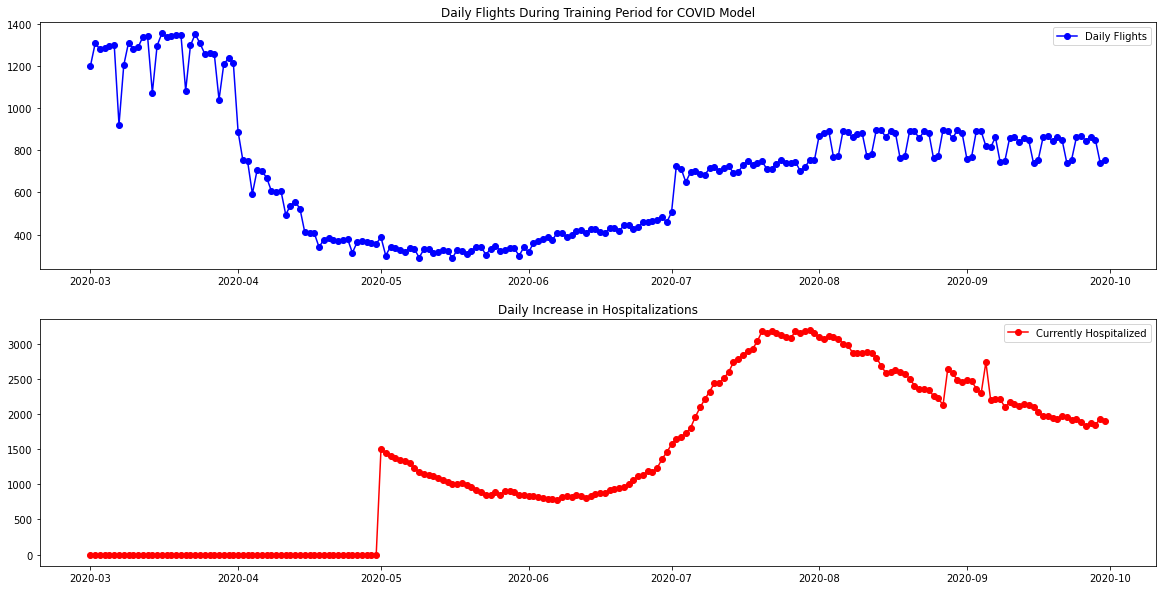

In [8]:
#do some plotting
%matplotlib inline

plt.figure(figsize=(20,10)) 
plt.subplot(2,2,1)
plt.subplot(211)
plt.title("Daily Flights During Training Period for COVID Model")
flight_cnts = plt.plot(explore['Date'], explore['counts_x'], color='b', label="Daily Flights", marker="o")
plt.legend(loc='upper right')

plt.subplot(212)
plt.title("Daily Increase in Hospitalizations")
covid_cnts = plt.plot(explore['Date'], explore['hospitalizedCurrently'], color='r', label="Currently Hospitalized", marker="o")
plt.legend(loc='upper right')
plt.show()

### Correlation

In [9]:
corr_matrix=explore.corr(method='pearson', min_periods=1)
with pd.option_context("display.min_rows", 50, "display.max_rows", 100, "display.max_columns", 5):
    display(corr_matrix)

,counts_x,DOW_num_x,...,positiveScore,score
counts_x,1.000000e+00,-1.516351e-02,...,NaN,NaN
DOW_num_x,-1.516351e-02,1.000000e+00,...,NaN,NaN
day_x,-2.882811e-02,-3.856866e-03,...,NaN,NaN
month_num_x,-5.532171e-02,-3.508886e-03,...,NaN,NaN
week_of_year_x,-5.848560e-02,-3.664452e-02,...,NaN,NaN
index,-5.901732e-02,-4.162384e-03,...,NaN,NaN
mint,-3.478883e-02,1.257624e-03,...,NaN,NaN
maxt,-1.359603e-01,8.626860e-02,...,NaN,NaN
temp,-1.103036e-01,5.329737e-02,...,NaN,NaN
dew,2.012337e-02,-3.880137e-02,...,NaN,NaN


### Split the data into train and test sets

In [10]:
# split into train based on time
train0 =dataset.time_between(datetime(2020, 7, 1, 0), datetime(2020, 11, 30, 0))
train0.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name).tail(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
148,21536,ATL,2020-11-26,GA,733,Thursday,3,26,November,11,...,461517.0,30762.0,461517.0,39.0,174.0,0.0,0.0,0.0,0.0,0.0
149,21542,ATL,2020-11-27,GA,905,Friday,4,27,November,11,...,464526.0,31722.0,464526.0,44.0,18.0,0.0,0.0,0.0,0.0,0.0
150,21548,ATL,2020-11-28,GA,1088,Saturday,5,28,November,11,...,467564.0,30611.0,467564.0,44.0,119.0,0.0,0.0,0.0,0.0,0.0
151,21554,ATL,2020-11-29,GA,1111,Sunday,6,29,November,11,...,469516.0,13903.0,469516.0,18.0,58.0,0.0,0.0,0.0,0.0,0.0
152,21560,ATL,2020-11-30,GA,1121,Monday,0,30,November,11,...,471563.0,11521.0,471563.0,10.0,42.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# split into test based on time
test0 = dataset.time_between(datetime(2020, 12, 1, 0), datetime(2020, 12, 31, 0))
test0.to_pandas_dataframe().reset_index(drop=True).head(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,21566,ATL,2020-12-01,GA,1060,Tuesday,1,1,December,12,...,476405.0,24519.0,476405.0,63.0,239.0,0.0,0.0,0.0,0.0,0.0
1,21572,ATL,2020-12-02,GA,865,Wednesday,2,2,December,12,...,482139.0,23997.0,482139.0,52.0,263.0,0.0,0.0,0.0,0.0,0.0
2,21578,ATL,2020-12-03,GA,967,Thursday,3,3,December,12,...,487978.0,33701.0,487978.0,81.0,245.0,0.0,0.0,0.0,0.0,0.0
3,21584,ATL,2020-12-04,GA,968,Friday,4,4,December,12,...,494354.0,38355.0,494354.0,77.0,212.0,0.0,0.0,0.0,0.0,0.0
4,21590,ATL,2020-12-05,GA,847,Saturday,5,5,December,12,...,499371.0,31180.0,499371.0,68.0,218.0,0.0,0.0,0.0,0.0,0.0


### There are too many input columns.  Do first round of feature selection

In [12]:
varsToKeep=['Departure_Airport',
'Date',
'Departure_state_x',
'counts_x',
'DOW_x',
'day_x',
'month_x',
'mint',
'maxt',
'temp',
'dew',
'humidity',
'wspd',
'precip',
'precipcover',
'snowdepth',
'visibility',
'cloudcover',
'sealevelpressure',
'weathertype',
'conditions',
'positiveIncrease',
'deathIncrease',
'hospitalizedIncrease']

# =============================================================================
# removed these for being cumulative
#'positive',
#'probableCases',
#'hospitalizedCurrently',
#'inIcuCurrently',
#'onVentilatorCurrently',
#'death',

#removed these for being missing
#'wgust',
#'windchill',
#'heatindex',
# =============================================================================

In [13]:
train=train0.keep_columns(varsToKeep)
test=test0.keep_columns(varsToKeep)

In [14]:
#print for viewing
train.to_pandas_dataframe().reset_index(drop=True).head(5)

,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,...,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease
0,ATL,2020-07-01,GA,505,Wednesday,1,July,69.2,82.1,75.0,...,8.33,0.0,9.9,62.1,1013.1,Light Rain,"Rain, Partially cloudy",2946.0,22.0,224.0
1,ATL,2020-07-02,GA,725,Thursday,2,July,71.0,89.0,79.0,...,16.67,0.0,9.7,52.2,1012.6,"Lightning Without Thunder, Thunderstorm, Rain, Heavy Rain","Rain, Partially cloudy",3472.0,22.0,225.0
2,ATL,2020-07-03,GA,714,Friday,3,July,74.9,91.1,82.8,...,0.00,0.0,9.8,49.6,1013.4,Mist,Partially cloudy,2784.0,7.0,153.0
3,ATL,2020-07-04,GA,650,Saturday,4,July,74.9,89.9,81.2,...,12.50,0.0,9.1,49.2,1013.0,"Lightning Without Thunder, Mist, Thunderstorm, Light Rain, Smoke Or Haze","Rain, Partially cloudy",2826.0,1.0,90.0
4,ATL,2020-07-05,GA,697,Sunday,5,July,74.0,91.1,82.7,...,0.00,0.0,7.2,53.7,1013.4,"Mist, Fog, Smoke Or Haze",Partially cloudy,2197.0,3.0,32.0


In [15]:
#print for viewing
test.to_pandas_dataframe().reset_index(drop=True).head(5)

,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,...,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease
0,ATL,2020-12-01,GA,1060,Tuesday,1,December,29.0,43.1,35.2,...,0.00,0.0,9.9,32.6,1020.4,None,Partially cloudy,4842.0,63.0,239.0
1,ATL,2020-12-02,GA,865,Wednesday,2,December,28.1,53.9,39.7,...,0.00,0.0,9.9,19.9,1026.4,None,Clear,5734.0,52.0,263.0
2,ATL,2020-12-03,GA,967,Thursday,3,December,33.1,55.1,44.9,...,0.00,0.0,9.9,70.6,1026.0,"Mist, Light Rain",Partially cloudy,5839.0,81.0,245.0
3,ATL,2020-12-04,GA,968,Friday,4,December,42.2,60.1,49.5,...,29.17,0.0,9.1,85.2,1018.5,"Mist, Rain, Heavy Rain, Light Rain","Rain, Overcast",6376.0,77.0,212.0
4,ATL,2020-12-05,GA,847,Saturday,5,December,38.0,56.9,45.4,...,0.00,0.0,9.9,15.8,1019.2,None,Clear,5017.0,68.0,218.0


# Modeling

### Set forecast horizon

In [16]:
forecast_horizon = 30

### Train the model

In [17]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq='D',
    feature_lags='auto'
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             #blocked_models = ['Prophet'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters,
                             enable_voting_ensemble=False)

In [18]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion()

Running on remote.
No run_configuration provided, running on flights-cluster with default configuration
Running on remote compute: flights-cluster
Parent Run ID: AutoML_9a53ecd9-9e03-4e34-8213-a999963e8e73

Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STAT

{'runId': 'AutoML_9a53ecd9-9e03-4e34-8213-a999963e8e73',
 'target': 'flights-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-04-05T11:48:58.249434Z',
 'endTimeUtc': '2021-04-05T12:18:55.086819Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'flights-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"COVID_model_JP","subscription_id":"f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17","resource_group":"hackathon","workspace_name":"iteration1_ml","region":"eastus2","compute_target":"flights-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_valid

# Results

### Retrieve the Best Model

In [19]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps
#fitted_model

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        lookback_features_removed=False,
                        pipeline=<azureml.automl.runtime.featurizer.transformer.timeseries.forecasting_pipeline.AzureMLForecastPipeline object at 0x7f9401d5d780>,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>,
                        time_index_non_holiday_features=['_automl_quarter',
                                                         '_automl_month',
                                                         '_automl_day',
                                                         '_automl_wday',
                                                         '_automl_qday',
                                                         '_automl_yday'])),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=[10, 90], with_centering=False,
               with_scaling=True)),
 ('LassoLars',
  LassoLars(alpha=0.001, copy_X=True, eps=2.

### View featurization

In [20]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Departure_Airport',
 'Departure_state_x',
 'DOW_x',
 'day_x',
 'month_x',
 'mint',
 'maxt',
 'temp',
 'dew',
 'humidity',
 'wspd',
 'precip',
 'precipcover',
 'snowdepth',
 'visibility',
 'cloudcover',
 'sealevelpressure',
 'weathertype',
 'conditions',
 'positiveIncrease',
 'deathIncrease',
 'hospitalizedIncrease',
 '_automl_target_col_WASNULL',
 'day_x_WASNULL',
 'mint_WASNULL',
 'maxt_WASNULL',
 'temp_WASNULL',
 'dew_WASNULL',
 'humidity_WASNULL',
 'wspd_WASNULL',
 'precip_WASNULL',
 'precipcover_WASNULL',
 'snowdepth_WASNULL',
 'visibility_WASNULL',
 'cloudcover_WASNULL',
 'sealevelpressure_WASNULL',
 'positiveIncrease_WASNULL',
 'deathIncrease_WASNULL',
 'hospitalizedIncrease_WASNULL',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_yday']

In [21]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Departure_Airport,Categorical,No,1,[LabelEncoder]
1,Departure_state_x,Categorical,No,1,[LabelEncoder]
2,DOW_x,Categorical,No,1,[LabelEncoder]
3,day_x,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,month_x,Categorical,No,1,[LabelEncoder]
5,mint,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,maxt,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,dew,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]"


### Forecast against the test sample

In [22]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

In [23]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

###### method from:
https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb

In [24]:
# from:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb

import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

#### Align Datasets

In [25]:
df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
df_all

,Date,_automl_dummy_grain_col,predicted,Departure_Airport,Departure_state_x,DOW_x,day_x,month_x,mint,maxt,...,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease,counts_x
0,2020-12-01,_automl_dummy_grain_col,1019.36,ATL,GA,Tuesday,1,December,29.00,43.10,...,0.00,9.90,32.60,1020.40,None,Partially cloudy,4842.00,63.00,239.00,1060
1,2020-12-02,_automl_dummy_grain_col,1036.80,ATL,GA,Wednesday,2,December,28.10,53.90,...,0.00,9.90,19.90,1026.40,None,Clear,5734.00,52.00,263.00,865
2,2020-12-03,_automl_dummy_grain_col,1088.76,ATL,GA,Thursday,3,December,33.10,55.10,...,0.00,9.90,70.60,1026.00,"Mist, Light Rain",Partially cloudy,5839.00,81.00,245.00,967
3,2020-12-04,_automl_dummy_grain_col,1141.86,ATL,GA,Friday,4,December,42.20,60.10,...,0.00,9.10,85.20,1018.50,"Mist, Rain, Heavy Rain, Light Rain","Rain, Overcast",6376.00,77.00,212.00,968
4,2020-12-05,_automl_dummy_grain_col,1133.49,ATL,GA,Saturday,5,December,38.00,56.90,...,0.00,9.90,15.80,1019.20,None,Clear,5017.00,68.00,218.00,847
5,2020-12-06,_automl_dummy_grain_col,1185.05,ATL,GA,Sunday,6,December,38.00,56.00,...,0.00,9.80,87.30,1015.50,"Mist, Light Rain","Rain, Overcast",2034.00,13.00,38.00,967
6,2020-12-07,_automl_dummy_grain_col,1129.58,ATL,GA,Monday,7,December,35.00,48.80,...,0.00,9.30,70.70,1012.00,"Mist, Light Rain",Partially cloudy,5285.00,45.00,231.00,958
7,2020-12-08,_automl_dummy_grain_col,1057.23,ATL,GA,Tuesday,8,December,30.80,47.90,...,0.00,9.90,4.60,1018.90,None,Clear,5577.00,22.00,191.00,836
8,2020-12-09,_automl_dummy_grain_col,1074.06,ATL,GA,Wednesday,9,December,29.90,62.00,...,0.00,9.90,42.50,1019.30,None,Partially cloudy,5512.00,48.00,279.00,860
9,2020-12-10,_automl_dummy_grain_col,1139.88,ATL,GA,Thursday,10,December,39.80,68.00,...,0.00,9.90,9.20,1019.70,Mist,Clear,7623.00,54.00,277.00,968


### Score Test Data

[Test data scores]

median_absolute_error:   168.684
root_mean_squared_error:   188.992
normalized_median_absolute_error:   0.400
normalized_root_mean_squared_log_error:   0.402
r2_score:   -1.000
root_mean_squared_log_error:   0.199
spearman_correlation:   0.270
explained_variance:   0.005
mean_absolute_error:   158.059
normalized_mean_absolute_error:   0.375
normalized_root_mean_squared_error:   0.448
mean_absolute_percentage_error:   18.288


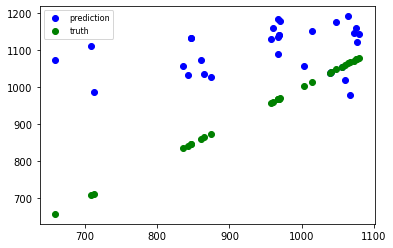

In [26]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

### Plot the results

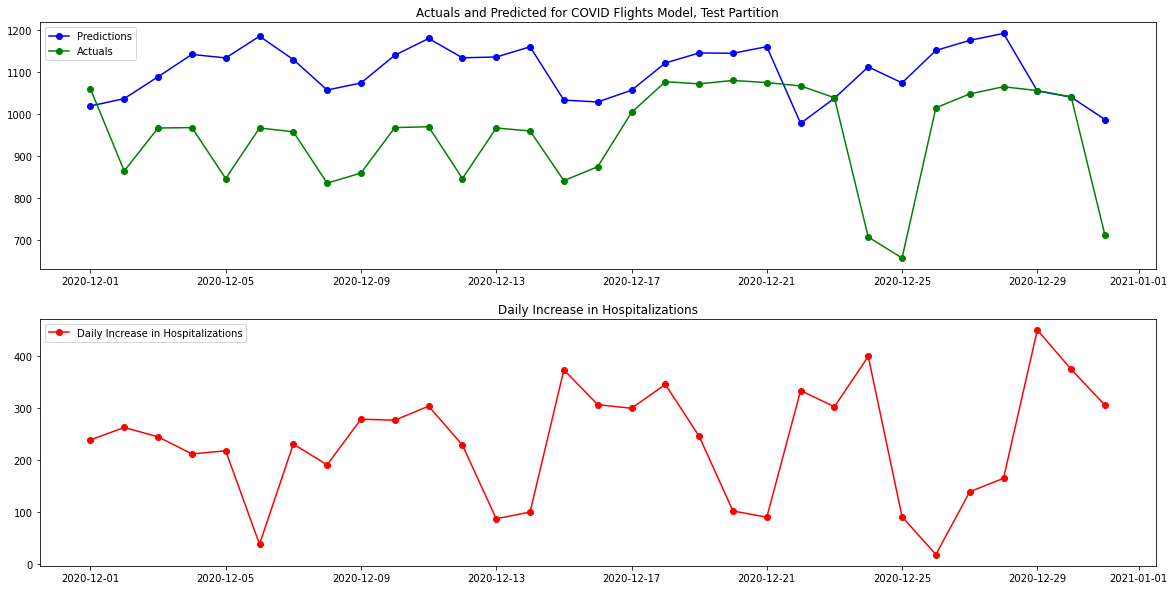

In [27]:
#plot the actual vs predicted as a time series plot
%matplotlib inline
plt.figure(figsize=(20,10)) 
plt.subplot(211)
plt.title("Actuals and Predicted for COVID Flights Model, Test Partition")
test_pred = plt.plot(df_all['Date'], df_all['predicted'], color='b', label="Predictions", marker="o")
test_actuals = plt.plot(df_all['Date'], df_all[target_column_name], color='g', label="Actuals", marker="o")
plt.legend(loc='upper left')
plt.subplot(212)
plt.title("Daily Increase in Hospitalizations")
covid= plt.plot(df_all['Date'], df_all['hospitalizedIncrease'], color='r', label="Daily Increase in Hospitalizations", marker="o")
plt.legend(loc='upper left')
plt.show()

### Confirm the run is completed

In [28]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…